## Batch Effect Testing 
We used t-SNE plot and PCA plot ML1, ML2, and ML4 datasets. Datasets are separated with different colors and the regression value with different shapes.<br>

In this notebook following experiments are performed <br>
1. Tested batch effect in a raw dataset where no features in any dataset have performed any normalization.<br>
     Observation: A batch effect is seen for the ML4 dataset for 8 and 16 concentrations.

2. Tested Batch Effect in min-max normalized dataset. <br>
        Method: Performed min-max normalization for each feature in the dataset separately.<br>
        Observation: Batch effect is slightly reduced when using min-max normalization

3. Tested Batch Effect using ComBat Normalization.
        Method: Performed ComBat Normalization after performing min-max Normalization. <br>
        Observation: After performing ComBat Normalization Ml1, Ml2, and ML4 dataset has close distribution and in the plots the clusters are
        grouped according to the concentration instead of batches.

4. Tested Batch Effect using Z-Score Normalization.
        Method: Performed Z-score Normalization. <br>
        Observation: After performing Z-score Normalization Ml1, Ml2, and ML4 dataset has close distribution and in the plots, the clusters           are grouped according to the concentration instead of batches.
       
   


In [13]:
import sys
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
import seaborn as sns
import os


from src.load_dataset import load_dataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from pycombat import Combat

import matplotlib.pyplot as plt

In [36]:
def tsen_pca_viz(data, batch_labels, labels, filename='', plot_type='pca'):
    p1, p2       =  ('t-SNE-1', 't-SNE-2')
    tsne         = PCA(n_components=2) if plot_type=='pca' else TSNE(n_components=2, random_state=42)
    tsne_result  = tsne.fit_transform(data)
    
    # Convert t-SNE result to a DataFrame for easier plotting
    tsne_df          = pd.DataFrame(data=tsne_result, columns=[p1, p2])
    tsne_df['Batch'] = batch_labels
    tsne_df['labels'] = labels

    os.makedirs('batch_effect', exist_ok=True)

    # Creating the main figure and gridspec for the marginal plots
    fig  = plt.figure(figsize=(8, 8))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

    
    ax_main = fig.add_subplot(grid[1:4, 0:3])
    sns.scatterplot(x=p1, y=p2, hue='Batch', style='labels', data=tsne_df, palette='deep', markers=['o', 's', '^'], s=20, ax=ax_main)
    ax_main.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    

    ax_top  = fig.add_subplot(grid[0, 0:3], sharex=ax_main)
    sns.kdeplot(data=tsne_df, x=p1, hue='Batch', fill=True, common_norm=False, palette='deep', alpha=0.5, ax=ax_top)


    ax_right = fig.add_subplot(grid[1:4, 3], sharey=ax_main)
    sns.kdeplot(data=tsne_df, x=p2, hue='Batch', fill=True, common_norm=False, palette='deep', alpha=0.5, ax=ax_right, vertical=True)
    
    plt.savefig(os.path.join(os.path.realpath(f'../results/batch_effect/{filename}.png')), dpi=300, pad_inches=0, bbox_inches='tight')


In [15]:
ML1_X, ML1_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=False, split=False)
ML2_X, ML2_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=False, split=False)
ML4_X, ML4_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=False, split=False)

In [16]:
conc         = 'all'
data         = pd.concat([ML1_X, ML2_X, ML4_X]) if conc=='all' else pd.concat([ML1_X[ML1_y==conc], ML2_X[ML2_y==conc], ML4_X[ML4_y==conc]])
batch_labels = np.repeat(['ML1', 'ML2', 'ML4'], repeats= [len(ML1_X), len(ML2_X), len(ML4_X)] if conc=='all' else [ML1_y.value_counts()[conc], ML2_y.value_counts()[conc], ML4_y.value_counts()[conc]])
labels       = ML1_y.values.tolist() + ML2_y.values.tolist() + ML4_y.values.tolist()

/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_85834/3374159921.py:28: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=tsne_df, x=p2, hue='Batch', fill=True, common_norm=False, palette='deep', alpha=0.5, ax=ax_right, vertical=True)


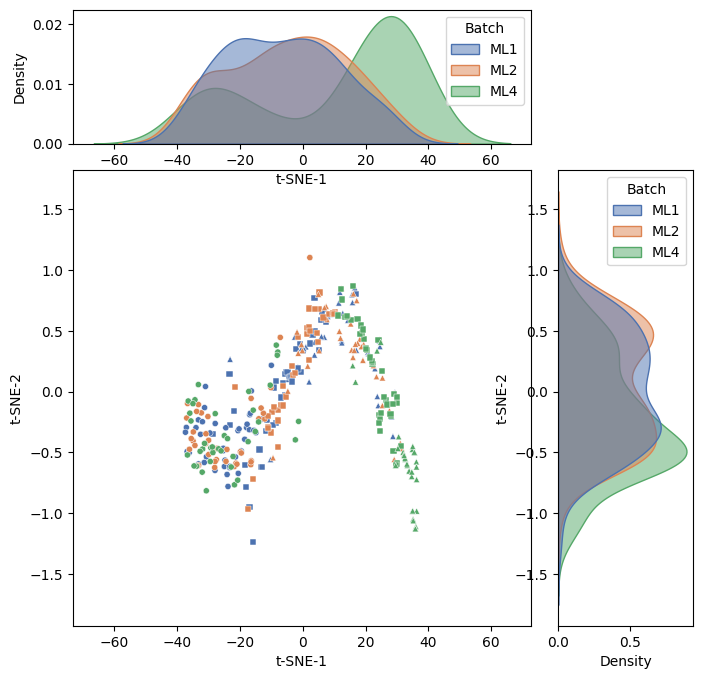

In [17]:
experiment_name = 'batch_effect_raw'
tsen_pca_viz(data, batch_labels, labels, filename=experiment_name, plot_type='t-sne')

In [18]:
features = data.values

# Apply ComBat
combat      = Combat()
combat_data = combat.fit_transform(features, batch_labels)
combat_df   = pd.DataFrame(combat_data, columns=data.columns)
combat_df

,"univariate, area(S)",peak curvature,"univariate, V_max(S)",vcenter,"univariate, max(S)","univariate, mean(S)","univariate, std(S)","univariate, max(dS/dV)","univariate, min(dS/dV)","univariate, max(dS/dV) - min(dS/dV)","univariate, V_max(dS/dV)","univariate, V_min(dS/dV)","univariate, area(dS/dV)"
0,5.069484,101.458447,1.057591,1.058617,0.077905,0.007230,0.018947,1.725856,-2.015569,3.771108,1.028406,1.079877,0.155845
1,4.000338,96.108340,1.058011,1.057531,0.063851,0.005712,0.015270,1.453908,-1.728288,3.209023,1.032571,1.084352,0.127674
2,11.510038,244.164417,1.056438,1.059802,0.178810,0.016476,0.043133,3.846387,-4.657895,8.540446,1.032571,1.079877,0.357621
3,7.131991,164.586647,1.070176,1.072540,0.116052,0.010128,0.027716,2.550394,-3.292712,5.865513,1.040901,1.093302,0.232065
4,9.706086,245.990084,1.056228,1.059703,0.152870,0.013854,0.036344,3.387972,-3.839515,7.271945,1.028406,1.079877,0.305712
...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,-0.440781,26.203141,0.975986,1.021558,-0.002295,-0.000665,0.000586,0.156416,-0.147092,0.260131,1.070430,1.017306,-0.004559
358,0.860764,37.660963,0.994729,1.007410,0.008848,0.001258,0.002491,0.278075,-0.174466,0.407257,0.947142,1.045970,0.017721
359,0.469802,11.827716,0.988537,1.007410,0.003369,0.000688,0.001221,0.215249,-0.081772,0.251541,0.971115,1.045970,0.006757
360,0.367772,42.026520,0.973392,1.025096,0.002692,0.000546,0.000868,0.187654,-0.097831,0.240821,0.981389,1.061895,0.005351


In [19]:
combat = Combat()
scaler = combat.fit(data.values, batch_labels)

result = scaler.transform(data.values[0:3], ['ML1', 'ML2', 'ML4'])
result

array([[ 5.06948396e+00,  1.01458447e+02,  1.05759115e+00,
         1.05861694e+00,  7.79054593e-02,  7.22970073e-03,
         1.89473901e-02,  1.72585641e+00, -2.01556934e+00,
         3.77110755e+00,  1.02840571e+00,  1.07987712e+00,
         1.55845151e-01],
       [ 3.79642402e+00,  8.67650997e+01,  1.06265493e+00,
         1.06107769e+00,  5.95939162e-02,  5.42066375e-03,
         1.43948950e-02,  1.35670692e+00, -1.53588939e+00,
         2.95233739e+00,  1.03507983e+00,  1.09006611e+00,
         1.19162323e-01],
       [ 6.00307663e+00,  1.13351895e+02,  1.05807243e+00,
         1.06188232e+00,  8.65583624e-02,  8.59134574e-03,
         2.13966617e-02,  1.83834496e+00, -1.96385095e+00,
         3.75280263e+00,  1.02933428e+00,  1.08737400e+00,
         1.73117296e-01]])

/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_85834/3374159921.py:28: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=tsne_df, x=p2, hue='Batch', fill=True, common_norm=False, palette='deep', alpha=0.5, ax=ax_right, vertical=True)


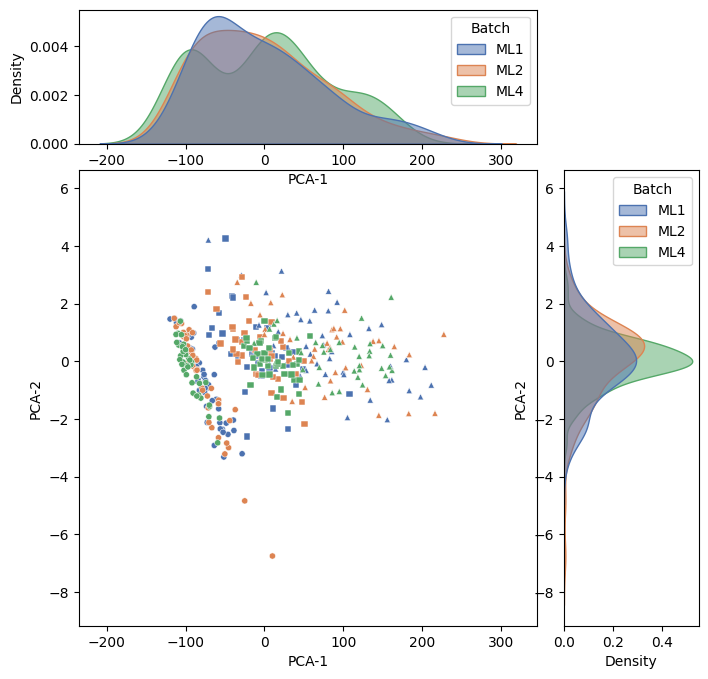

In [20]:
experiment_name = 'batch_effect_ComBat_withoutNorm'
tsen_pca_viz(combat_df, batch_labels, labels, filename=experiment_name)

## ComBat after Normalization (MinMax)

In [32]:
# Load normalized dataset
normalization    = True
standardize_type = 'min_max'

ML1_X, ML1_y  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=False)
ML2_X, ML2_y  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=False)
ML4_X, ML4_y  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=False)

In [33]:
conc         = 'all'
data         = pd.concat([ML1_X, ML2_X, ML4_X]) if conc=='all' else pd.concat([ML1_X[ML1_y==conc], ML2_X[ML2_y==conc], ML4_X[ML4_y==conc]])
batch_labels = np.repeat(['ML1', 'ML2', 'ML4'], repeats= [len(ML1_X), len(ML2_X), len(ML4_X)] if conc=='all' else [ML1_y.value_counts()[conc], ML2_y.value_counts()[conc], ML4_y.value_counts()[conc]])
labels       = ML1_y.values.tolist() + ML2_y.values.tolist() + ML4_y.values.tolist()

/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_85834/1448918993.py:28: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=tsne_df, x=p2, hue='Batch', fill=True, common_norm=False, palette='deep', alpha=0.5, ax=ax_right, vertical=True)


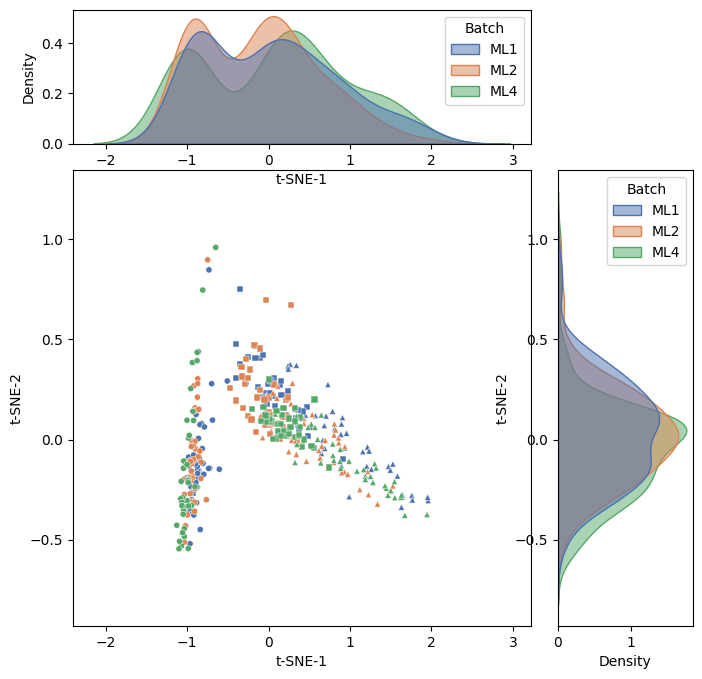

In [37]:
experiment_name = f'batch_effect_{standardize_type}'
tsen_pca_viz(data, batch_labels, labels, filename=experiment_name, plot_type='pca')

In [66]:
features = data.values

# Apply ComBat
combat      = Combat()
combat_data = combat.fit_transform(features, batch_labels)
combat_df   = pd.DataFrame(combat_data, columns=data.columns)

/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_45469/3374159921.py:28: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=tsne_df, x=p2, hue='Batch', fill=True, common_norm=False, palette='deep', alpha=0.5, ax=ax_right, vertical=True)


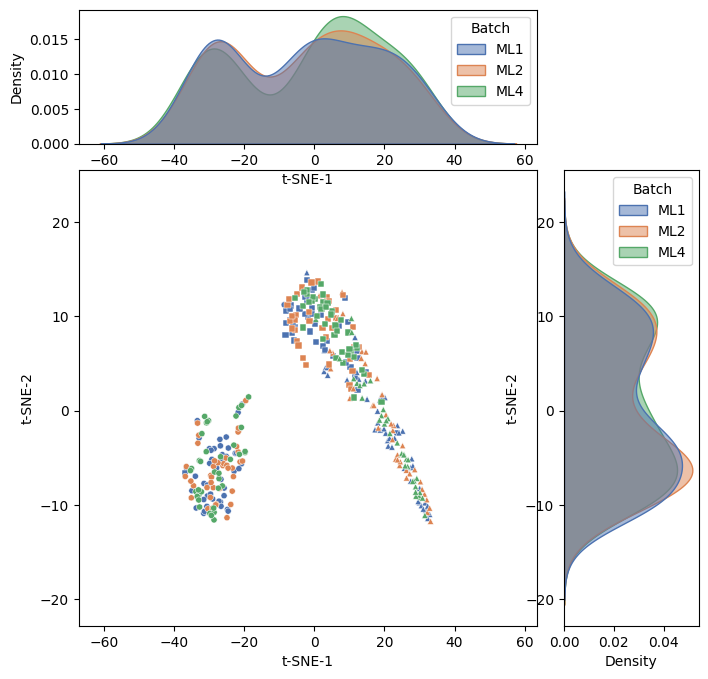

In [67]:
experiment_name = f'batch_effect_{standardize_type}_ComBat'
tsen_pca_viz(combat_df, batch_labels, labels, filename=experiment_name, plot_type='t-sne')

In [29]:
# Load normalized dataset
normalization    = True
standardize_type = 'min_max'
normalize_blanks = False

ML1_X, ML1_y  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, normalize_blanks=normalize_blanks, split=False)
ML2_X, ML2_y  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, normalize_blanks=normalize_blanks, split=False)
ML4_X, ML4_y  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, normalize_blanks=normalize_blanks, split=False)

In [30]:
conc         = 'all'
data         = pd.concat([ML1_X, ML2_X, ML4_X]) if conc=='all' else pd.concat([ML1_X[ML1_y==conc], ML2_X[ML2_y==conc], ML4_X[ML4_y==conc]])
batch_labels = np.repeat(['ML1', 'ML2', 'ML4'], repeats= [len(ML1_X), len(ML2_X), len(ML4_X)] if conc=='all' else [ML1_y.value_counts()[conc], ML2_y.value_counts()[conc], ML4_y.value_counts()[conc]])
labels       = ML1_y.values.tolist() + ML2_y.values.tolist() + ML4_y.values.tolist()

/var/folders/6p/0ctyq1md3qqbfn509nf4xfgr0000gp/T/ipykernel_85834/3374159921.py:28: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=tsne_df, x=p2, hue='Batch', fill=True, common_norm=False, palette='deep', alpha=0.5, ax=ax_right, vertical=True)


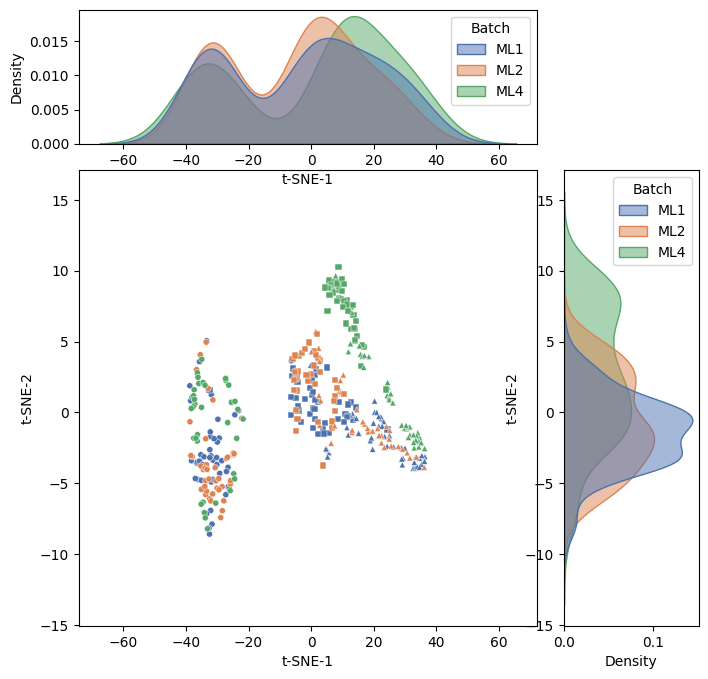

In [31]:
experiment_name = f'batch_effect_{standardize_type}'
tsen_pca_viz(data, batch_labels, labels, filename=experiment_name, plot_type='t-sne')